### Importing Libraries:

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import os


### Device configuration

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Define image transformations

In [10]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(30),
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])


### load dataset

In [11]:
# Set the data directory path
data_dir = "PlantVillage" 

# Load the dataset with PyTorch ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])


create data loader

In [12]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


Training the model

In [13]:
# Load a pre-trained model (ResNet18) and modify the final layer for your dataset
model = models.resnet18(pretrained=True)

# Freeze the earlier layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes
num_classes = len(full_dataset.classes)  # Automatically gets the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to the chosen device
model = model.to(device)


c:\Users\Ravin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ravin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


define loss function and optimizer

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


training loop


In [16]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

# Hyperparameters
num_epochs = 10
best_accuracy = 0.0
patience = 5  # For early stopping
counter = 0

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track accuracy and loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation phase
    model.eval()
    valid_correct_predictions = 0
    valid_total_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            valid_correct_predictions += (predicted == labels).sum().item()
            valid_total_predictions += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_accuracy = valid_correct_predictions / valid_total_predictions
    print(f'Validation Accuracy: {valid_accuracy:.4f}')

    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Validation Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    # Save the model with the best accuracy on the validation set
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0  # Reset counter for early stopping
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

    # Step the scheduler
    scheduler.step()

print(f'Best Validation Accuracy: {best_accuracy:.4f}')


Epoch [1/10], Loss: 0.8943, Accuracy: 0.7594
Validation Accuracy: 0.8551
Validation Precision: 0.8612, Recall: 0.8551, F1 Score: 0.8498
Epoch [2/10], Loss: 0.4925, Accuracy: 0.8581
Validation Accuracy: 0.8777
Validation Precision: 0.8795, Recall: 0.8777, F1 Score: 0.8754
Epoch [3/10], Loss: 0.4091, Accuracy: 0.8767
Validation Accuracy: 0.8970
Validation Precision: 0.9010, Recall: 0.8970, F1 Score: 0.8980
Epoch [4/10], Loss: 0.3667, Accuracy: 0.8854
Validation Accuracy: 0.8970
Validation Precision: 0.8998, Recall: 0.8970, F1 Score: 0.8971
Epoch [5/10], Loss: 0.3412, Accuracy: 0.8906
Validation Accuracy: 0.8980
Validation Precision: 0.9034, Recall: 0.8980, F1 Score: 0.8980
Epoch [6/10], Loss: 0.3041, Accuracy: 0.9064
Validation Accuracy: 0.9058
Validation Precision: 0.9052, Recall: 0.9058, F1 Score: 0.9044
Epoch [7/10], Loss: 0.2906, Accuracy: 0.9087
Validation Accuracy: 0.9079
Validation Precision: 0.9072, Recall: 0.9079, F1 Score: 0.9072
Epoch [8/10], Loss: 0.3010, Accuracy: 0.9033
Val

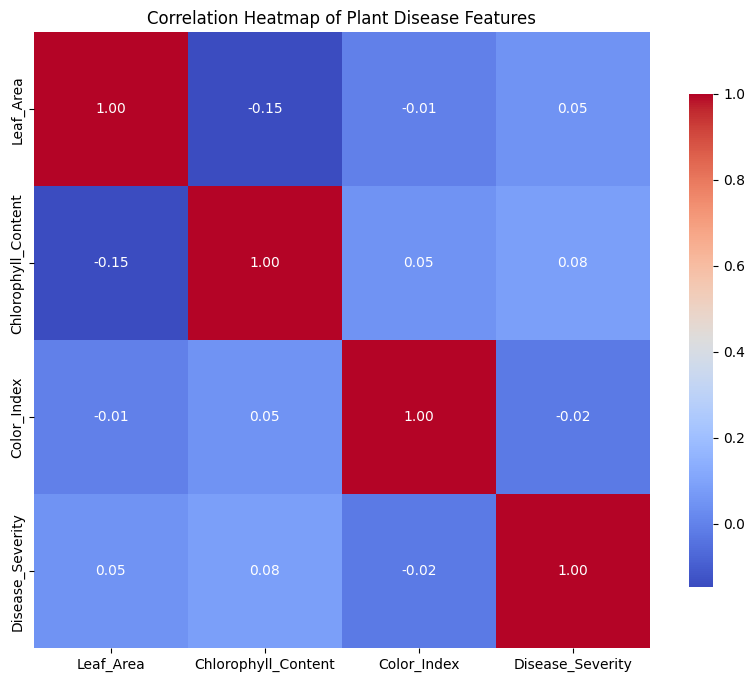

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample dataset creation (replace this with your actual dataset)
data = {
    'Leaf_Area': np.random.rand(100),            # Leaf area feature
    'Chlorophyll_Content': np.random.rand(100),   # Chlorophyll content feature
    'Color_Index': np.random.rand(100),           # Color index feature
    'Disease_Severity': np.random.rand(100) * 10  # Severity of disease (0-10 scale)
}

df = pd.DataFrame(data)

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Plant Disease Features')
plt.show()
